In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os 
import sys
import copy


Import the data

In [2]:
def Signal_Processing(file_name,start=None, end=None, upper_lim=1000,lower_lim=100,sampling_frequency=100,cut_off_frequency=2,drop_head=5,drop_tail=-5):
    if file_name[-3:]=='lsx':
        original_data=pd.read_excel(file_name)
        
    elif file_name[-3:]=='csv':
        original_data=pd.read_csv(file_name)
    original_data = original_data.filter(regex='^(?!Unnamed)')
    signal_index = [int(col) for n, col in enumerate(original_data.columns) if (n + 1) % 3 == 1]  
    data_cleared=original_data.dropna(axis=1,how='all')
    #slice different serieses
    data_sliced = []
    column_num = len(data_cleared.columns)

    for i in range(0, column_num, 2):
        df_sliced = data_cleared.iloc[:, i:i+2].copy()  
        df_sliced.columns = ['t', 'i' ]
        # 删除所有值为空的行
        new_df_sliced = df_sliced.dropna(axis=0, how="all").copy()
        # 确保 new_df_sliced 不是空的再进行操作
        if not new_df_sliced.empty:
            new_df_sliced.loc[:, new_df_sliced.columns[0]] -= new_df_sliced.iloc[0, 0]
        data_sliced.append(new_df_sliced)
    return data_sliced


Slice the data and clear the NaN rows

In [8]:
import os
cur_dir=os.getcwd()
fn='direction_2.xlsx'
pth="data_final"
data=Signal_Processing(os.path.join(cur_dir,pth,fn))


In [4]:

result = [int(col) for n, col in enumerate(data.columns) if (n + 1) % 3== 1]
print(result)

AttributeError: 'list' object has no attribute 'columns'

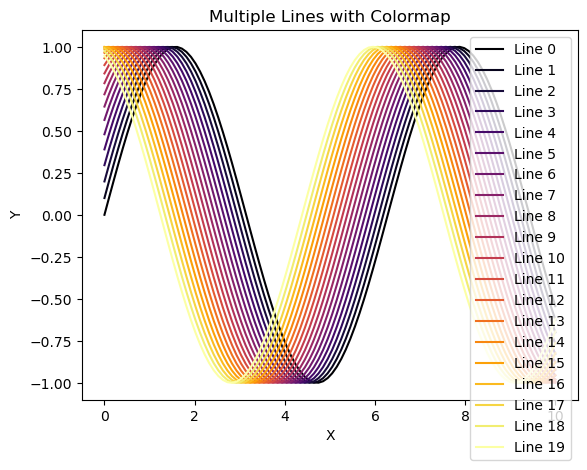

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 生成数据
x = np.linspace(0, 10, 100)
num_lines = 20

# 创建颜色映射
cmap = plt.get_cmap('inferno')
norm = plt.Normalize(0, num_lines - 1)

# 绘制多条线
for i in range(num_lines):
    y = np.sin(x + i * 0.1)
    color = cmap(norm(i))
    plt.plot(x, y, color=color, label=f'Line {i}')

# 添加图例和标签
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Multiple Lines with Colormap')

# 显示图形
plt.show()

In [ ]:
from scipy import signal

Bessel_Filter LPF,changing sampling_frequencu and cutt off frequency

In [5]:
def Bessel_Filter(data,sampling_frequency=None,order=4,cut_off_frequency=40):
    normalized_cutoff=cut_off_frequency/(0.5*sampling_frequency)
    b,a=signal.bessel(order, normalized_cutoff, btype='low', analog=False)
    filtered_data=signal.filtfilt(b,a,data)
    return filtered_data
    
    
    
    
    

In [6]:
def Draw_Plot(time,current,format="-", start=0, end=None,x_range=60):
    plt.plot(time[start:end],current[start:end],color='black')
    plt.xlabel('Time/ms')
    plt.ylabel('Current/pA')
    plt.grid=False
    plt.xlim(-1,x_range)
    

In [10]:
plt.rcParams['figure.dpi'] = 300
for i in range(-10,-1):
    try_data=data[i]
    Draw_Plot(try_data['t'],try_data['i'],x_range=try_data.shape[0]/18)
    plt.savefig(os.path.join(os.getcwd(),'schematic_picture','raw','d2',str(i)+'.png'))
    plt.close('all')
    

Using Bessel LFP to filter the data

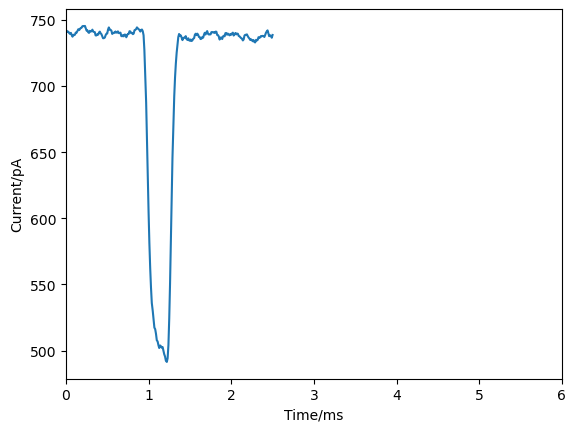

In [29]:
sampling_frequency=100
cut_off_frequency=40
filtered_data=Bessel_Filter(data[2]['i'],sampling_frequency=sampling_frequency,cut_off_frequency=cut_off_frequency)
try_data=data[2]
Draw_Plot(try_data['t'],filtered_data,x_range=6)

Downsampling Reducing Calculation Task

In [13]:
def Down_sampling(data, factor):
    down_sampled_data=signal.decimate(data,factor)
    return down_sampled_data
    

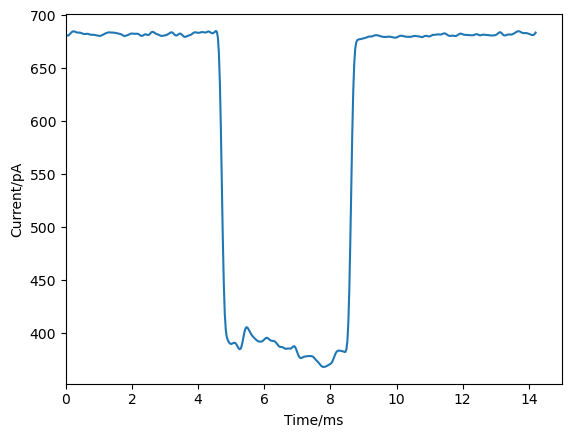

In [49]:
filtered_curve=np.array([try_data['t'],filtered_data])
factor=3
down_sampled_data=Down_sampling(filtered_curve, factor=factor)
Draw_Plot(down_sampled_data[0],down_sampled_data[1],x_range=15)


Interplotation-rearange the length of the series

In [59]:
from scipy.interpolate import interp1d

In [57]:
def interplotation(data,target_length):
    inter_func = interp1d(data.iloc[:,0], data.iloc[:,1], kind='cubic')  # 使用三次样条插值
    time_new=np.linspace(data.iloc[0,0],data.iloc[-1,0],target_length)
    current_interpolated = inter_func(time_new)
    return pd.DataFrame(np.array([time_new, current_interpolated]).T)
    

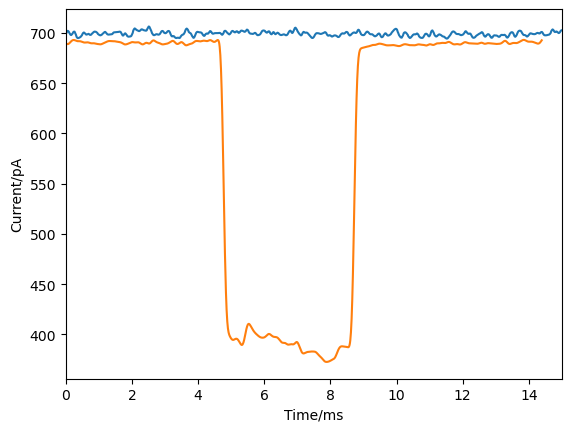

In [62]:
filtered_curve_dataframe=pd.DataFrame(filtered_curve.T)
interplotted_curve=interplotation(filtered_curve_dataframe,2000)
Draw_Plot(interplotted_curve[0],interplotted_curve[1],x_range=15)

Draw_Plot(try_data['t'],filtered_data,x_range=15)


In [31]:
def normalized_translocation(data,threshold=450,drop_head=5,drop_tail=-5):
    translocation_region=data[data.iloc[:,1]<threshold]
    translocation_region=translocation_region.iloc[drop_head:drop_tail,:]
    translocation_region.iloc[:,1]=(translocation_region.iloc[:,1]-translocation_region.iloc[:,1].mean())/translocation_region.iloc[:,1].std()
    translocation_region.iloc[:,0]=translocation_region.iloc[:,0]-translocation_region.iloc[0,0]
    return translocation_region


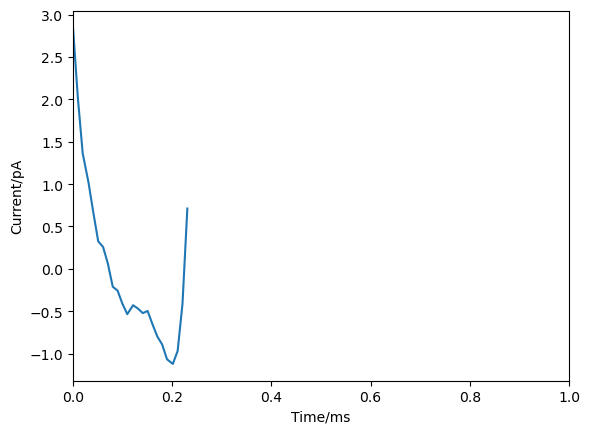

In [38]:
filtered_curve_dataframe=pd.DataFrame(np.array([try_data['t'],filtered_data]).T)
threshold=min(filtered_curve_dataframe.iloc[:,1])+200
normalized_data=normalized_translocation(filtered_curve_dataframe,threshold=threshold)
Draw_Plot(normalized_data.iloc[:,0],normalized_data.iloc[:,1],x_range=1)

All_data processing

In [53]:
sampling_frequency=100
cut_off_frequency=40
factor=3
processed_data=[]
for series in data:
    filtered_current=Bessel_Filter(series['i'],sampling_frequency=sampling_frequency,cut_off_frequency=cut_off_frequency)
    filtered_curve=np.array([series['t'],filtered_current])
    if len(filtered_curve[0])>3000:
        down_sampled_curve=Down_sampling(filtered_curve, factor=3)
    else:
        down_sampled_curve=filtered_curve
    filtered_curve_dataframe=pd.DataFrame(down_sampled_curve.T)
    normalized_data=normalized_translocation(filtered_curve_dataframe,threshold=min(filtered_curve_dataframe.iloc[:,1])+150,drop_head=5)
    processed_data.append(normalized_data)

Plot the processed data

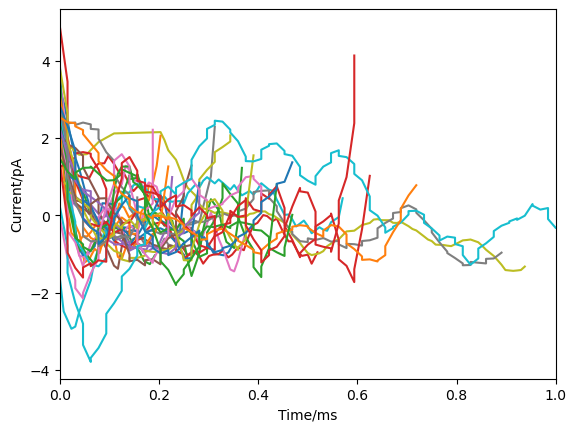

In [54]:
for series in processed_data[0:]:
    Draw_Plot(series.iloc[:,0],series.iloc[:,1],x_range=1)
    

pick the longest series and carry out interplotation on other serieses

In [55]:
def normalized_time_axis(data):
    normalized_translocation_region=copy.deepcopy(data)
    normalized_translocation_region.iloc[:,0]=(normalized_translocation_region.iloc[:,0]-min(normalized_translocation_region.iloc[:,0]))/(max(normalized_translocation_region.iloc[:,0])-min(normalized_translocation_region.iloc[:,0]))
    return normalized_translocation_region

Using interplotation to align the signals

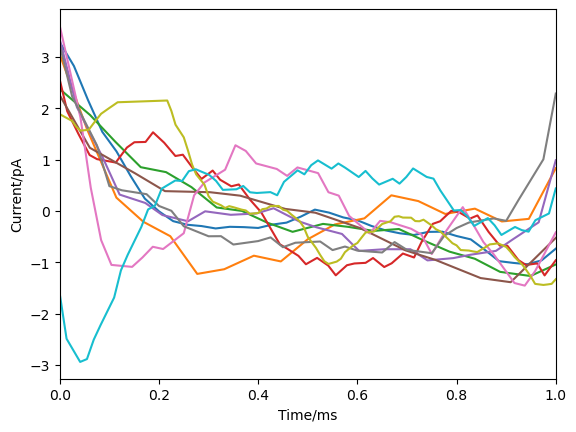

In [64]:
target_data=[series for series in processed_data  ]
max_len=max([len(series) for series in target_data])
max_index=[len(series) for series in target_data].index(max_len)

time_normalized_data=[normalized_time_axis(series) for series in target_data]

for series in time_normalized_data[0:10]:
    Draw_Plot(series.iloc[:,0],series.iloc[:,1],x_range=1)



Using Min-Max normalization to align the signals

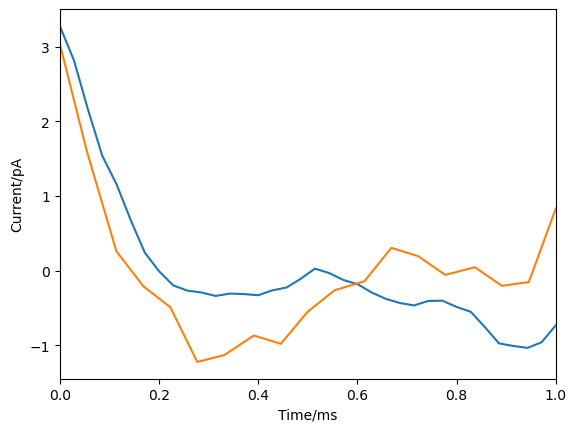

In [65]:
for series in time_normalized_data[0:2]:
    Draw_Plot(series.iloc[:,0],series.iloc[:,1],x_range=1)

In [23]:
from tslearn.metrics import dtw_path, dtw
from tslearn.preprocessing import TimeSeriesResampler
import seaborn as sns


In [24]:
inter_series_1=interplotation_data[0]
original_series_1=target_data[0]
original_series_2=target_data[1]
inter_series_2=interplotation_data[1]
original_dtw_distance=dtw(original_series_1,original_series_2)
dtw_distance_2=dtw(inter_series_1,inter_series_2)



Show Path

In [25]:
path,distance=dtw_path(original_series_1,original_series_2)
#print(original_dtw_distance, dtw_distance_2)
print(path)

[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 2), (7, 3), (8, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (10, 13), (11, 14), (12, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (13, 20), (13, 21), (13, 22), (13, 23), (14, 24), (15, 25), (16, 26), (17, 26), (18, 26), (19, 27), (20, 27), (21, 28), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (26, 33), (26, 34), (26, 35), (26, 36), (26, 37), (26, 38), (26, 39), (26, 40), (26, 41), (26, 42), (26, 43), (26, 44), (26, 45), (26, 46), (26, 47), (26, 48), (26, 49), (26, 50), (26, 51), (26, 52), (27, 53), (28, 54), (29, 55), (30, 56), (31, 57), (32, 58), (33, 59), (34, 60), (35, 60), (36, 60), (37, 61), (38, 61), (39, 62), (40, 62), (41, 63), (42, 64), (43, 65), (44, 66), (44, 67), (44, 68), (44, 69), (44, 70), (44, 71), (44, 72), (44, 73), (44, 74), (44, 75), (44, 76), (44, 77), (44, 78), (44, 79), (44, 80), (44, 81), (44, 82), (44, 83), (44, 84), (44, 85), (44, 86), (44, 87), (44, 88), (44, 89), 

Time normalized data

In [26]:
tn_series_1=time_normalized_data[0]
tn_series_2=time_normalized_data[1]
dtw_distance_3=dtw(tn_series_1,tn_series_2)

In [27]:
print(original_dtw_distance,dtw_distance_2,dtw_distance_3)

22.648634935533863 31.267720580240784 6.841220318064753


In [28]:
def Calculate_Plot_Aligned_Signal(series_1, series_2):
    path, distance=dtw_path(series_1,series_2)
    normalized_distance=distance/(len(series_1)+len(series_2))
    aligned_series_1=np.zeros((len(path),2))
    aligned_series_2=np.zeros((len(path),2))
 
    for i, (idx1, idx2) in enumerate(path):
        np_series_1=series_1.to_numpy()
        np_series_2=series_2.to_numpy()
        aligned_series_1[i] = np_series_1[idx1]
        aligned_series_2[i] = np_series_2[idx2]
        
    aligned_series_1_time=[x[0] for x in aligned_series_1]
    aligned_series_2_time=[x[0] for x in aligned_series_2]
    aligned_series_1_current=[x[1] for x in aligned_series_1]
    aligned_series_2_current=[x[1] for x in aligned_series_2]
    if series_1.shape[0]>series_2.shape[0]:
        plt.plot(aligned_series_1_time,aligned_series_1_current)
        plt.plot(aligned_series_1_time,aligned_series_2_current)
        plt.show
    else:
        plt.plot(aligned_series_2_time,aligned_series_1_current)
        plt.plot(aligned_series_2_time,aligned_series_2_current)
        plt.show
        
   
    return normalized_distance
    
    
    
    
    
    
    

0.01336175843372022

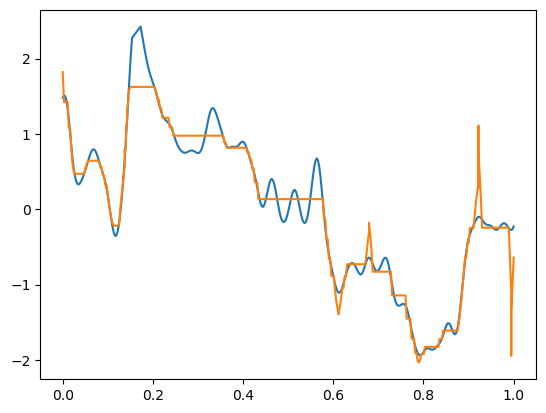

In [29]:

Calculate_Plot_Aligned_Signal(tn_series_1,tn_series_2)



In [30]:
dtw_matrix=np.zeros((len(time_normalized_data),len(time_normalized_data)))

for i in range(len(time_normalized_data)-1):
    for j in range (i+1, len(time_normalized_data)):
        series_1=time_normalized_data[i]
        series_2=time_normalized_data[j]
        distance=dtw(series_1,series_2)
        normalized_distance=distance/(len(series_1)+len(series_2))
        dtw_matrix[i,j]=normalized_distance
        dtw_matrix[j,i]=normalized_distance
rows_sums=dtw_matrix.sum(axis=1)
min_index=np.argmin(rows_sums)
normalized_dtw_matrix=dtw_matrix/np.amax(dtw_matrix)

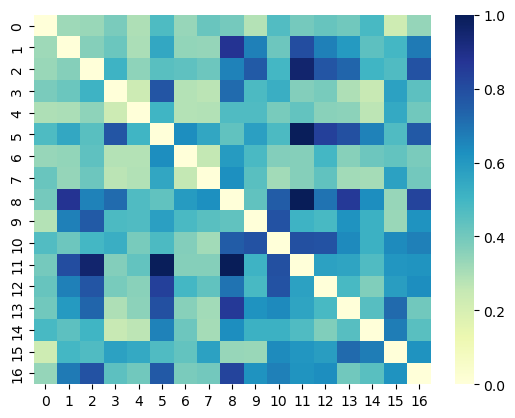

17 4


In [26]:
sns.heatmap(normalized_dtw_matrix, annot=False, fmt=".2f", cmap="YlGnBu")
plt.show()
print(len(rows_sums),min_index)

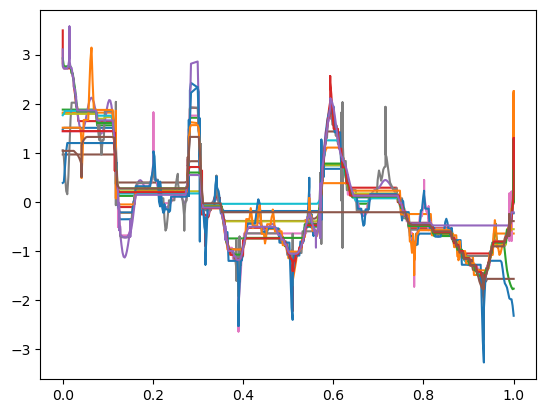

In [31]:
aligned_data=[]
series_standard=time_normalized_data[min_index]
np_series_standard=series_standard.to_numpy()
np_series_standard_time=np_series_standard[:,0].T
np_series_standard_current=np_series_standard[:,1].T
for i in range(len(time_normalized_data)-1):
    if i != min_index:
        series=time_normalized_data[i]
        standard_series=np_series_standard
        path,_=dtw_path(series,series_standard)
        aligned_series=np.zeros((len(path),2))
        aligned_standard_series=np.zeros((len(path),2))
        for i, (idx1, idx2) in enumerate(path):
            np_series=series.to_numpy()
            aligned_series[i] = np_series[idx1]
            aligned_standard_series[i]=standard_series[idx2]
        #aligned_series_time=[x[0] for x in aligned_series]
        aligned_series_current=[x[1] for x in aligned_series]
        aligned_standard_series_time=[x[0] for x in aligned_standard_series]
        aligned_data.append(np.array([aligned_standard_series_time,aligned_series_current]))
    else:
        aligned_data.append(np.array([np_series_standard_time,np_series_standard_current]))
        
for series in aligned_data:
    plt.plot(series[0,:], series[1,:])
    
plt.show()

In [40]:
func_range=np.arange(0,1,1/len(np_series_standard_time))
sin_func=np.sin(10*np.pi*func_range)
sin_series=pd.DataFrame(np.array([func_range,sin_func]).T)

0.014919781961107917

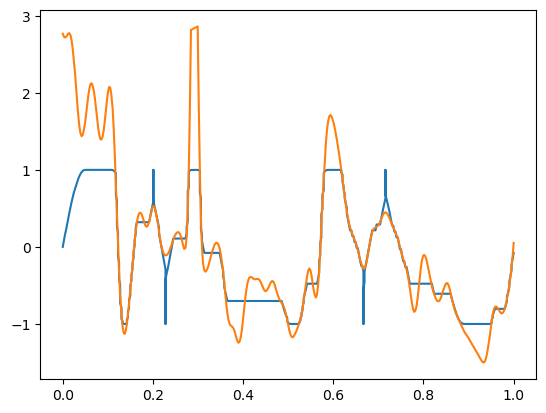

In [41]:
a=Calculate_Plot_Aligned_Signal(sin_series,series_standard)
a

In [34]:
import random
def add_noise(time,noise_level=0.03,seed=None):
    
    rnd = np.random.RandomState(seed)
    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise
    

Remove duplicate numbers

In [35]:
aligned_data_unique=[]
for series in aligned_data:
    unique_series_time,idx=np.unique(series[0,:],return_index=True)
    unique_series_current=series[1,:][idx]
    aligned_data_unique.append(np.array([unique_series_time,unique_series_current]))

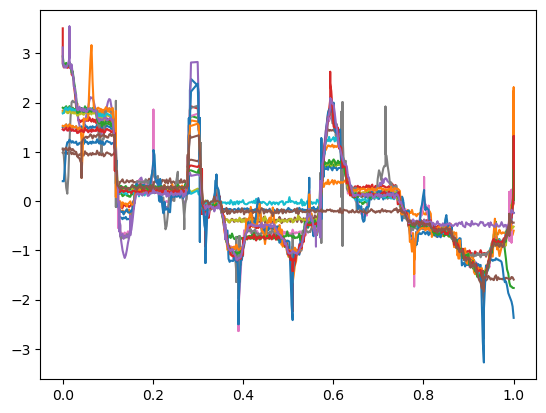

In [38]:
len_aligned_data=np.array([series.shape[1] for series in aligned_data_unique])
max_aligned_len=len_aligned_data.max()
max_len_index=np.argmax(len_aligned_data)
interplotation_aligned_data=[interplotation(pd.DataFrame(series.T), max_len) for series in aligned_data_unique]

Average current plot

Average current plot

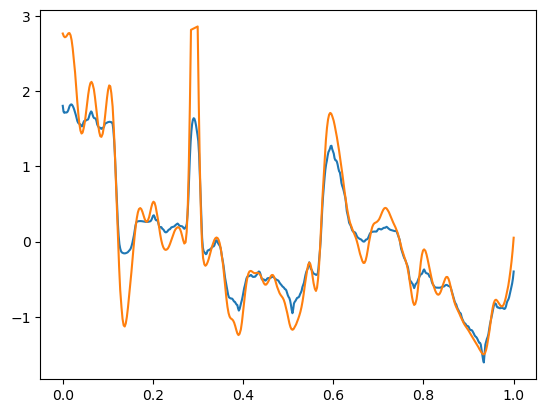

In [65]:
import copy
average_current=np.zeros(series.shape[0])
for series in interplotation_aligned_data:
    average_current+=series.iloc[:,1].to_numpy().T
average_current/=len(interplotation_aligned_data)
nearst_series=copy.deepcopy(average_current)
time=np.linspace(0,1,max_len)
plt.plot(time,average_current)
plt.plot(np_series_standard_time,np_series_standard_current)
plt.show()

In [42]:
from tslearn.barycenters import softdtw_barycenter

In [69]:
resampler_length=TimeSeriesResampler(sz=500)
standard_series_resampled=resampler_length.fit_transform(np_series_standard_current).ravel()
nearst_series_resampled=resampler_length.fit_transform(nearst_series).ravel()


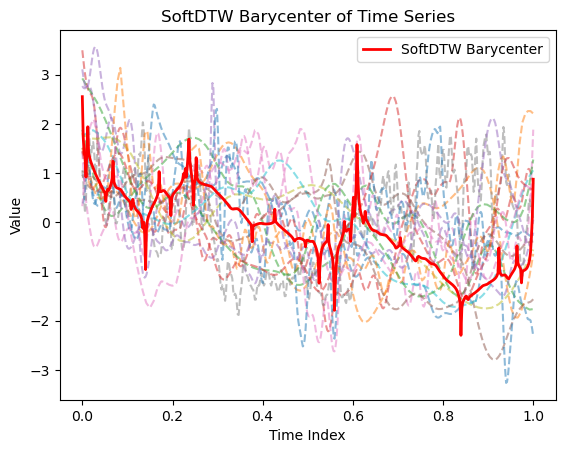

In [76]:
resampler_length=TimeSeriesResampler(sz=500)
currents_resampled=[resampler_length.fit_transform(series).ravel() for series in time_normalized_data_np[:]]
nearst_series_resampled=resampler_length.fit_transform(nearst_series).ravel()
# 步骤 3: 计算 SoftDTW 重心
# 设置 gamma 参数，控制 SoftDTW 的平滑程度
gamma = 0.1
# 调用 softdtw_barycenter 函数计算重心
barycenter = softdtw_barycenter(currents_resampled, gamma=gamma)

# 步骤 4: 可视化结果
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100
time1=np.linspace(0,1,500)
# 绘制原始时间序列
for ts in currents_resampled:
    plt.plot(time1,ts, linestyle='--', alpha=0.5)

# 绘制计算得到的重心
plt.plot(time1,barycenter, label='SoftDTW Barycenter', color='red', linewidth=2)

# 添加图例和标题
plt.legend()
plt.title('SoftDTW Barycenter of Time Series')
plt.xlabel('Time Index')
plt.ylabel('Value')

# 显示图形
plt.show()

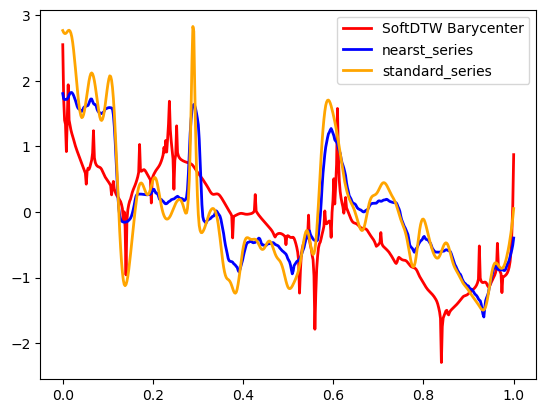

In [77]:
plt.plot(time1,barycenter, label='SoftDTW Barycenter', color='red', linewidth=2)
plt.plot(time1,nearst_series_resampled, label='nearst_series', color='blue', linewidth=2)
plt.plot(time1,standard_series_resampled, label='standard_series', color='orange', linewidth=2)
plt.legend()
plt.show()



In [ ]:
def barycenter_plot(events,resample_to=400, gamma=None, label="",tol=0.001,c='g',alphahaze=0.2):
    
    #resample all events in the set to a fixed size
    resampler_long=TimeSeriesResampler(sz=resample_to)
    currents_resampled=[resampler_long.fit_transform(event.current/event.I_0).ravel() for event in events]
    print("resampling size: ", resample_to)
    
    if gamma is None: # if gamma is not provided..
        gammas=[]
        for i in range (30):
            gammas.append(gamma_soft_dtw(currents_resampled[:],len(currents_resampled),i)) 
        gamma=np.mean(gammas) #estimate an optimal gamma by averaging many guesses
        print("auto gamma: ",gamma)
    else: # otherwise use the provided gamma
        print("gamma: ",gamma)
        
    # Now calculate the barycenter curve (b) for all events in the set using gamma    
    b=softdtw_barycenter(currents_resampled[:],max_iter=800,gamma=gamma,tol=1e-7) 
      
    # first plot the backdrops
    plt.plot (currents_resampled[0].ravel(), c='k',alpha=alphahaze,linewidth=0.2, label="50 resampled events")
    for i in range (1,len(events)):
        plt.plot (currents_resampled[i*1].ravel(), c='k',alpha=alphahaze,linewidth=0.2)
        
    # Then plot the barycenter curve   
    plt.plot (b,c=c,alpha=0.9, label= f'{label} soft DTW barycenter',linewidth=3)
    return(gamma)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

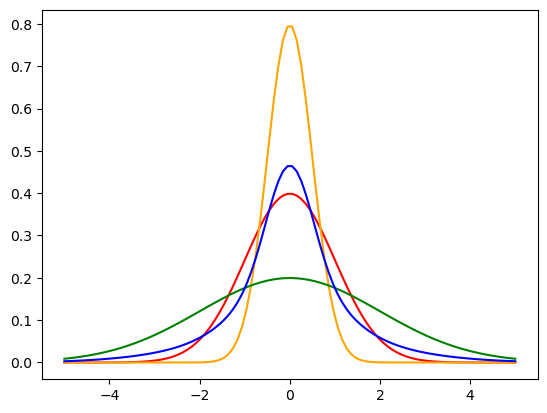

In [31]:
x_axis=np.linspace(-5,5,100)
gaussian_1=norm.pdf(x_axis,0,1)
gaussian_2=norm.pdf(x_axis,0,0.5)
gaussian_3=norm.pdf(x_axis,0,2)
plt.plot(x_axis,gaussian_1,color='red')
plt.plot(x_axis,gaussian_2,color='orange')
plt.plot(x_axis,gaussian_3,color='green')
plt.plot(x_axis,(gaussian_1+gaussian_2+gaussian_3)/3,color='blue')
plt.show()




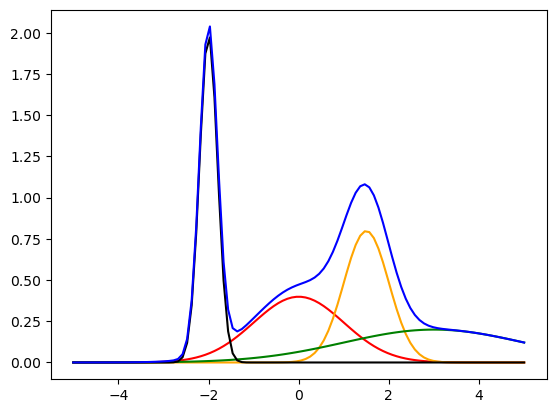

In [37]:
x_axis=np.linspace(-5,5,100)
gaussian_1=norm.pdf(x_axis,0,1)
gaussian_2=norm.pdf(x_axis,1.5,0.5)
gaussian_3=norm.pdf(x_axis,3,2)
gaussian_4=norm.pdf(x_axis,-2,0.2)
plt.plot(x_axis,gaussian_1,color='red')
plt.plot(x_axis,gaussian_2,color='orange')
plt.plot(x_axis,gaussian_3,color='green')
plt.plot(x_axis,gaussian_4,color='black')
plt.plot(x_axis,(gaussian_1+gaussian_2+gaussian_3+gaussian_4),color='blue')
plt.show()